In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import os
from sklearn.preprocessing import MinMaxScaler

In [3]:
file_path =r'C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\bitcoin_2021_2024.csv'

df = pd.read_csv(file_path, low_memory=False)

In [3]:
# prepare data (time)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

BTC Price History Graph

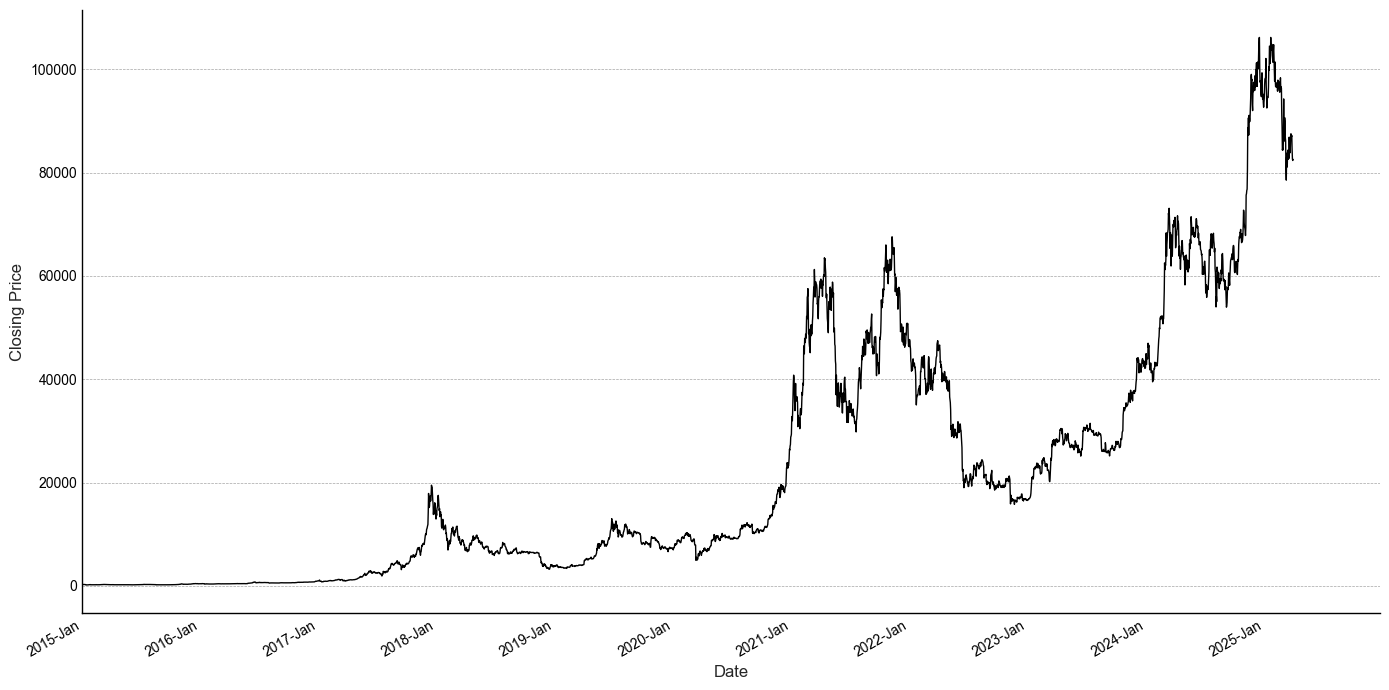

In [6]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(df.index, df['close'], color='black', linewidth=1.0, label='Daily Closing Price')

ax.set_xlim(left=pd.to_datetime('2015-01-01'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Closing Price', fontsize=12)
# ax.set_title('Bitcoin Daily Closing Prices (until March 2025)', fontsize=14)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15))

plt.xticks(rotation=30, ha='right')

ax.grid(True, which='major', axis='y', linestyle='--', linewidth='0.5', color='grey', alpha=0.7)
ax.grid(False, which='major', axis='x')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

plt.tight_layout()

plt.show()

Explore all google trend files

In [33]:
folder = r"C:\Users\Leo Hubmann\Desktop\thesis\data\gtrends_data\google_trends_output_daily_single"

csv_files = glob.glob(os.path.join(folder, "*.csv"))

all_dfs = []

for file in csv_files:
    
    df = pd.read_csv(file, usecols=[0, 1], low_memory=False)
    
    df.columns = ['Date', 'Trend']
    df['Date'] = pd.to_datetime(df['Date'])
    
    search_term = os.path.basename(file).split('_trend_daily')[0]
    df['Search Term'] = search_term
    
    all_dfs.append(df)

combined = pd.concat(all_dfs)

pivoted = combined.pivot(index='Date', columns='Search Term', values='Trend')

pivoted_smoothed = pivoted.rolling(window=7, min_periods=1).mean()
trend_data = pivoted_smoothed

btc_path = r"C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\bitcoin_2021_2024.csv"
btc_df = pd.read_csv(btc_path, usecols=['date', 'close'])
btc_df.columns = ['date', 'close']
btc_df['date'] = pd.to_datetime(btc_df['date'])
btc_df.set_index('date', inplace=True)

btc_df = btc_df.loc['2021-01-01':'2024-12-31']

btc_smooth = btc_df['close'].rolling(window=7, min_periods=1).mean()



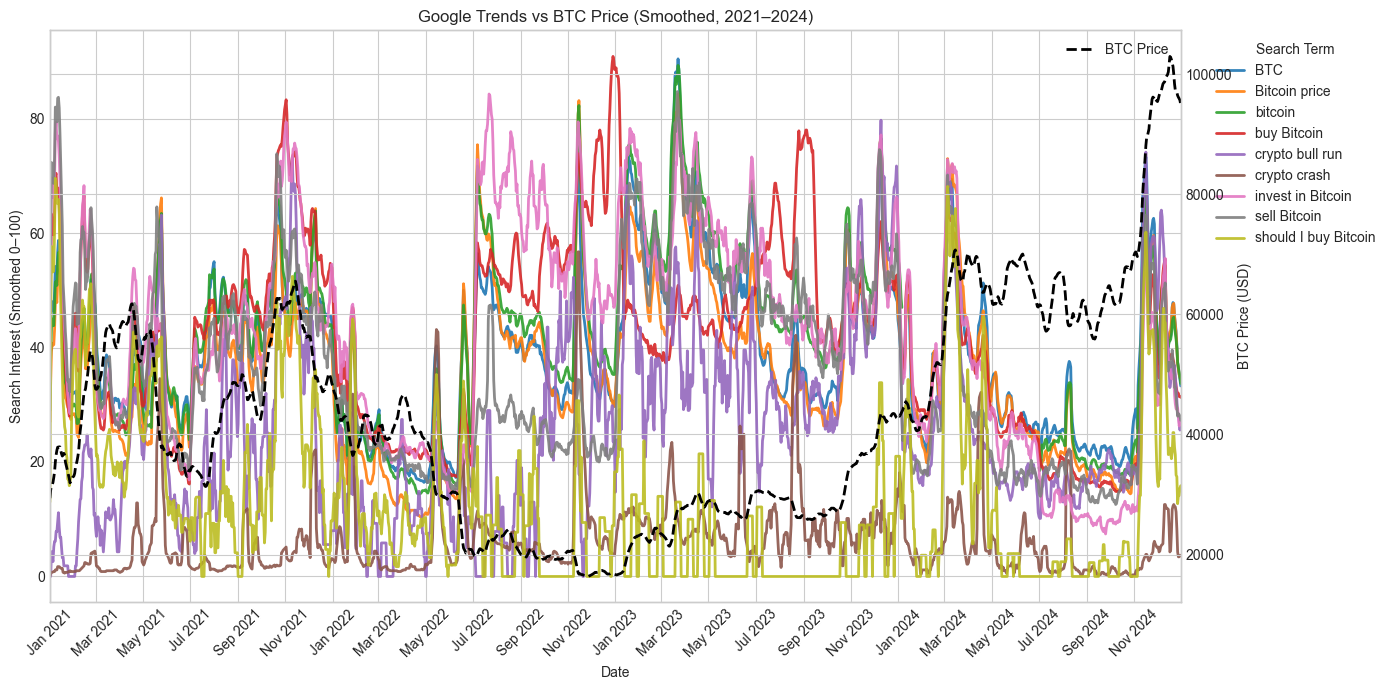

In [34]:
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot search trends
trend_data.plot(ax=ax1, linewidth=2, alpha=0.9)
ax1.set_ylabel("Search Interest (Smoothed 0–100)")
ax1.set_xlabel("Date")
ax1.legend(title="Search Term", bbox_to_anchor=(1.02, 1), loc='upper left')

# Format x-axis to show months
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Plot BTC price on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(btc_smooth.index, btc_smooth, color='black', linestyle='--', linewidth=2, label='BTC Price')
ax2.set_ylabel("BTC Price (USD)")
ax2.legend(loc='upper right')

plt.title("Google Trends vs BTC Price (Smoothed, 2021–2024)")
plt.tight_layout()
plt.show()

In [36]:
btc_returns = btc_df['close'].pct_change().dropna() * 100  # in %

avg_trend = pivoted.mean(axis=1)

avg_trend_smooth = avg_trend.rolling(window=7, min_periods=1).mean()

aligned = pd.DataFrame({
    'return': btc_returns,
    'trend': avg_trend_smooth
}).dropna()

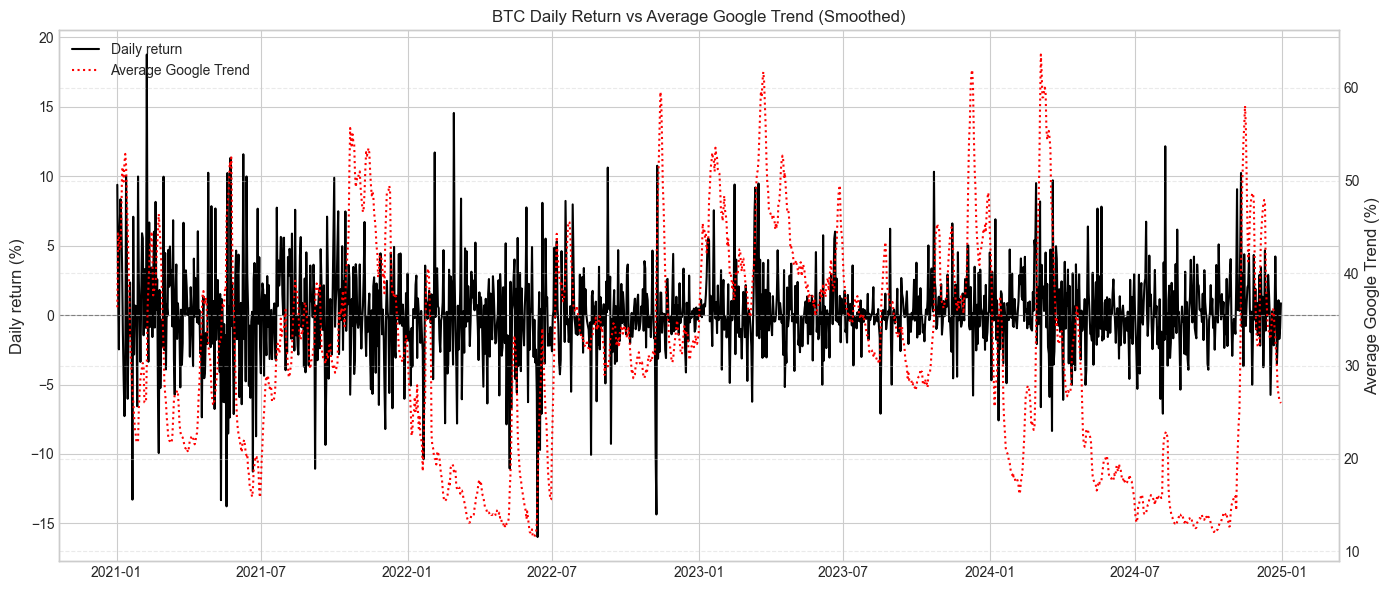

In [39]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# BTC return
ax1.plot(aligned.index, aligned['return'], color='black', label='Daily return')
ax1.set_ylabel("Daily return (%)", fontsize=12)
ax1.tick_params(axis='y')
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Trend on second y-axis
ax2 = ax1.twinx()
ax2.plot(aligned.index, aligned['trend'], color='red', linestyle=':', label='Average Google Trend')
ax2.set_ylabel("Average Google Trend (%)", fontsize=12)
ax2.tick_params(axis='y')

# Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Formatting
plt.title("BTC Daily Return vs Average Google Trend (Smoothed)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Weekly

In [42]:
positive_terms = [
    "buy Bitcoin", "crypto bull run", "invest in Bitcoin", "Bitcoin price", "should I buy Bitcoin"
]

negative_terms = [
    "sell Bitcoin", "crypto crash"  # could be neutral/uncertain
]

def classify_term(term):
    if term in positive_terms:
        return 1
    elif term in negative_terms:
        return -1
    else:
        return 0  # neutral or unknown

combined['Sentiment Tag'] = combined['Search Term'].apply(classify_term)

combined['Weighted'] = combined['Trend'] * combined['Sentiment Tag']

# Pivot to time series
daily_sentiment_index = combined.groupby('Date')['Weighted'].mean()

weekly_sentiment = daily_sentiment_index.resample('W').mean().shift(1)


In [43]:
btc_weekly = btc_df['close'].resample('W').last()
btc_weekly_return = btc_weekly.pct_change().shift(-1) * 100  # forward return

trend_weekly = avg_trend_smooth.resample('W').mean()

weekly_combined = pd.DataFrame({
    'return': btc_weekly_return,
    'sentiment_lagged': weekly_sentiment
}).dropna()

# weekly_combined = pd.DataFrame({
#     'return': btc_weekly_return,
#     'sentiment_lagged': trend_weekly.shift(1)  # use previous week's average
# }).dropna()

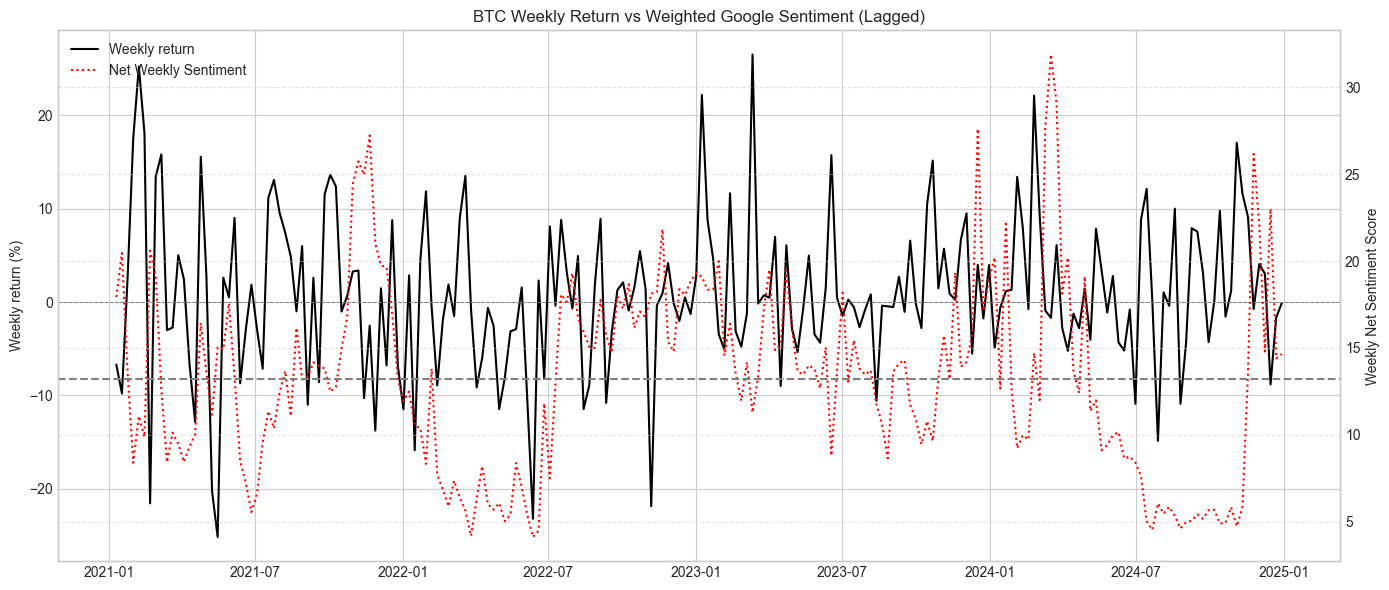

In [48]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot return
ax1.plot(weekly_combined.index, weekly_combined['return'], color='black', label='Weekly return')
ax1.set_ylabel("Weekly return (%)")
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.7)

# Plot sentiment
ax2 = ax1.twinx()
#ax2.plot(weekly_combined.index, weekly_combined['sentiment_lagged'], color='red', linestyle=':', label='Avg Google Trend')
ax2.plot(weekly_combined.index, weekly_combined['sentiment_lagged'], 
         color='red', linestyle=':', label='Net Weekly Sentiment')
ax2.set_ylabel("Weekly Net Sentiment Score")
#ax2.set_ylabel("Weekly avg Google Trend (%)")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("BTC Weekly Return vs Weighted Google Sentiment (Lagged)")
#plt.title("BTC Weekly Return vs Avg Weekly Google Trend (Lagged)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [46]:
weekly_combined.corr()

,return,sentiment_lagged
return,1.000000,-0.040567
sentiment_lagged,-0.040567,1.000000
